## 1. Пример импорта данных. Грузим данные

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
import numpy as np

In [3]:
file_path = r'C:\Users\eliza\Downloads\data (1).csv'  
data = pd.read_csv(file_path)

## 2. Понимаем, какая перед нами задача

In [4]:
print("Образец данных:")
print(data.head())

Образец данных:
        EducationSector IndividualProject  Age Gender City Influenced  \
0  Engineering Sciences                No   19   Male  Yes         No   
1  Engineering Sciences               Yes   22   Male   No        Yes   
2  Engineering Sciences                No   18   Male  Yes         No   
3  Engineering Sciences               Yes   20   Male  Yes        Yes   
4  Engineering Sciences               Yes   19   Male  Yes        Yes   

   Perseverance  DesireToTakeInitiative  Competitiveness  SelfReliance  \
0             2                       2                3             3   
1             3                       3                3             4   
2             3                       4                3             3   
3             3                       3                3             3   
4             2                       3                3             3   

   StrongNeedToAchieve  SelfConfidence  GoodPhysicalHealth MentalDisorder  \
0                    2 

In [9]:
data.isnull().sum()

EducationSector            0
IndividualProject          0
Age                        0
Gender                     0
City                       0
Influenced                 0
Perseverance               0
DesireToTakeInitiative     0
Competitiveness            0
SelfReliance               0
StrongNeedToAchieve        0
SelfConfidence             0
GoodPhysicalHealth         0
MentalDisorder             0
KeyTraits                  0
ReasonsForLack            91
y                          0
dtype: int64

In [10]:
data.drop(columns=['ReasonsForLack'], inplace=True)

## 3. Делаем предобработку данных

In [13]:
# Кодировка целевой переменной
label_encoder = LabelEncoder()
data['Adaptivity Level'] = label_encoder.fit_transform(data['y'])

# Разделение данных на признаки и целевую переменную
X = data.drop(columns=['y'])
y = data['y']

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Определение категориальных и числовых столбцов
categorical_columns = X_train.select_dtypes(include=['object']).columns
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

# OneHotEncoder для категориальных данных
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_categorical = ohe.fit_transform(X_train[categorical_columns])
X_test_categorical = ohe.transform(X_test[categorical_columns])

# StandardScaler для числовых данных (если есть)
scaler = StandardScaler()
if len(numerical_columns) > 0:
    X_train_numerical = scaler.fit_transform(X_train[numerical_columns])
    X_test_numerical = scaler.transform(X_test[numerical_columns])
else:
    X_train_numerical = np.array([]).reshape(X_train_categorical.shape[0], 0)
    X_test_numerical = np.array([]).reshape(X_test_categorical.shape[0], 0)

# Объединение обработанных данных
X_train_processed = np.hstack([X_train_categorical, X_train_numerical])
X_test_processed = np.hstack([X_test_categorical, X_test_numerical])

# Вывод размеров обработанных данных
print(f"Размеры тренировочной выборки: {X_train_processed.shape}, Тестовой выборки: {X_test_processed.shape}")

Размеры тренировочной выборки: (175, 33), Тестовой выборки: (44, 33)


# 4. Оформить данные в виде класса Dataset из библиотеки torch (как мы это делали на семинаре), а затем засунуть в Dataloader (тоже делали на семинаре).

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

# Определение класса Dataset
class AdaptivityDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Создание объектов Dataset
train_dataset = AdaptivityDataset(X_train_processed, y_train)
test_dataset = AdaptivityDataset(X_test_processed, y_test)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 5. Создание и обучение простой однослойной нейронной сети

Epoch 1/20, Train Loss: 0.6330, Test Loss: 0.6315
Epoch 2/20, Train Loss: 0.5975, Test Loss: 0.6075
Epoch 3/20, Train Loss: 0.5732, Test Loss: 0.5845
Epoch 4/20, Train Loss: 0.5495, Test Loss: 0.5624
Epoch 5/20, Train Loss: 0.5285, Test Loss: 0.5417
Epoch 6/20, Train Loss: 0.5077, Test Loss: 0.5222
Epoch 7/20, Train Loss: 0.4901, Test Loss: 0.5045
Epoch 8/20, Train Loss: 0.4740, Test Loss: 0.4864
Epoch 9/20, Train Loss: 0.4537, Test Loss: 0.4699
Epoch 10/20, Train Loss: 0.4386, Test Loss: 0.4538
Epoch 11/20, Train Loss: 0.4202, Test Loss: 0.4393
Epoch 12/20, Train Loss: 0.4090, Test Loss: 0.4247
Epoch 13/20, Train Loss: 0.4001, Test Loss: 0.4116
Epoch 14/20, Train Loss: 0.3807, Test Loss: 0.3990
Epoch 15/20, Train Loss: 0.3773, Test Loss: 0.3871
Epoch 16/20, Train Loss: 0.3632, Test Loss: 0.3752
Epoch 17/20, Train Loss: 0.3489, Test Loss: 0.3639
Epoch 18/20, Train Loss: 0.3379, Test Loss: 0.3533
Epoch 19/20, Train Loss: 0.3246, Test Loss: 0.3433
Epoch 20/20, Train Loss: 0.3167, Test Lo

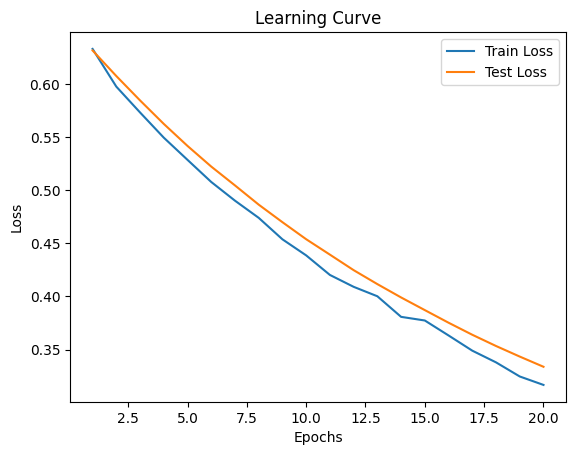

In [15]:

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Однослойная нейросеть
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.fc(x)

# Определение гиперпараметров
input_size = X_train_processed.shape[1]  # Количество признаков
output_size = len(label_encoder.classes_)  # Количество классов
learning_rate = 0.01
num_epochs = 20

# Инициализация модели, функции потерь и оптимизатора
model = SimpleNN(input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Списки для хранения значений потерь
train_losses = []
test_losses = []

# Функция для вычисления потерь
def compute_loss(dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for features, labels in dataloader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Обучение модели
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(compute_loss(test_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Построение кривой обучения
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

# 6.  Создание и обучение более сложной модели с одним скрытым слоем

Epoch 1/20, Train Loss: 0.7126, Test Loss: 0.6906
Epoch 2/20, Train Loss: 0.6648, Test Loss: 0.6503
Epoch 3/20, Train Loss: 0.6217, Test Loss: 0.6177
Epoch 4/20, Train Loss: 0.5929, Test Loss: 0.5883
Epoch 5/20, Train Loss: 0.5671, Test Loss: 0.5600
Epoch 6/20, Train Loss: 0.5334, Test Loss: 0.5336
Epoch 7/20, Train Loss: 0.5063, Test Loss: 0.5057
Epoch 8/20, Train Loss: 0.4752, Test Loss: 0.4759
Epoch 9/20, Train Loss: 0.4568, Test Loss: 0.4468
Epoch 10/20, Train Loss: 0.4123, Test Loss: 0.4164
Epoch 11/20, Train Loss: 0.3829, Test Loss: 0.3866
Epoch 12/20, Train Loss: 0.3561, Test Loss: 0.3581
Epoch 13/20, Train Loss: 0.3272, Test Loss: 0.3281
Epoch 14/20, Train Loss: 0.2910, Test Loss: 0.2990
Epoch 15/20, Train Loss: 0.2617, Test Loss: 0.2701
Epoch 16/20, Train Loss: 0.2317, Test Loss: 0.2430
Epoch 17/20, Train Loss: 0.2126, Test Loss: 0.2195
Epoch 18/20, Train Loss: 0.1854, Test Loss: 0.1953
Epoch 19/20, Train Loss: 0.1646, Test Loss: 0.1736
Epoch 20/20, Train Loss: 0.1452, Test Lo

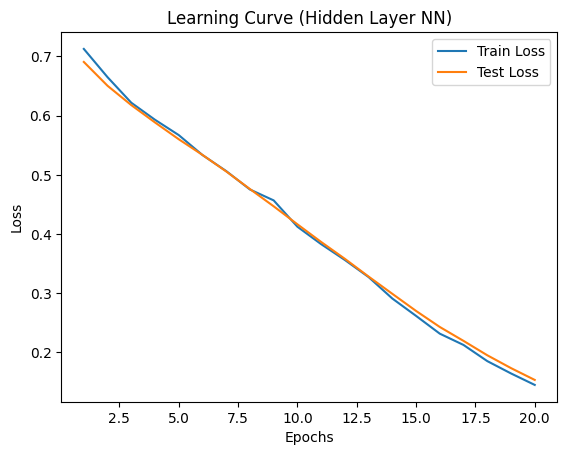

In [17]:

# Нейросеть с одним скрытым слоем
class HiddenLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(HiddenLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Определение гиперпараметров для новой модели
hidden_size = 64  # Размер скрытого слоя
learning_rate = 0.001
num_epochs = 20

# Инициализация модели, функции потерь и оптимизатора
model = HiddenLayerNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Списки для хранения значений потерь
train_losses = []
test_losses = []

# Обучение модели с одним скрытым слоем
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(compute_loss(test_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Построение кривой обучения
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve (Hidden Layer NN)")
plt.legend()
plt.show()

# 7. Создание и обучение более сложной модели с 3+ скрытыми слоями

Epoch 1/20, Train Loss: 0.6732, Test Loss: 0.6524
Epoch 2/20, Train Loss: 0.6331, Test Loss: 0.6113
Epoch 3/20, Train Loss: 0.5779, Test Loss: 0.5469
Epoch 4/20, Train Loss: 0.4981, Test Loss: 0.4526
Epoch 5/20, Train Loss: 0.3877, Test Loss: 0.3315
Epoch 6/20, Train Loss: 0.2687, Test Loss: 0.2068
Epoch 7/20, Train Loss: 0.1442, Test Loss: 0.1059
Epoch 8/20, Train Loss: 0.0656, Test Loss: 0.0438
Epoch 9/20, Train Loss: 0.0255, Test Loss: 0.0172
Epoch 10/20, Train Loss: 0.0095, Test Loss: 0.0080
Epoch 11/20, Train Loss: 0.0041, Test Loss: 0.0046
Epoch 12/20, Train Loss: 0.0023, Test Loss: 0.0031
Epoch 13/20, Train Loss: 0.0015, Test Loss: 0.0023
Epoch 14/20, Train Loss: 0.0011, Test Loss: 0.0019
Epoch 15/20, Train Loss: 0.0009, Test Loss: 0.0016
Epoch 16/20, Train Loss: 0.0007, Test Loss: 0.0014
Epoch 17/20, Train Loss: 0.0007, Test Loss: 0.0013
Epoch 18/20, Train Loss: 0.0006, Test Loss: 0.0012
Epoch 19/20, Train Loss: 0.0005, Test Loss: 0.0011
Epoch 20/20, Train Loss: 0.0005, Test Lo

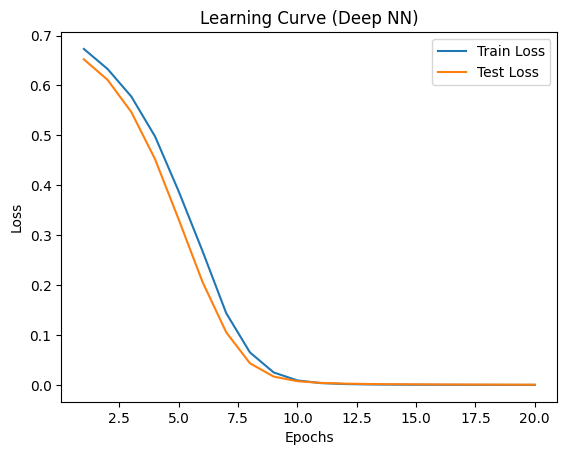

In [18]:

# Нейросеть с тремя скрытыми слоями
class DeepNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Определение гиперпараметров для более сложной модели
hidden_sizes = [128, 64, 32]  # Размеры скрытых слоев
learning_rate = 0.001
num_epochs = 20

# Инициализация модели, функции потерь и оптимизатора
model = DeepNN(input_size, hidden_sizes, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Списки для хранения значений потерь
train_losses = []
test_losses = []

# Обучение модели с тремя скрытыми слоями
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(compute_loss(test_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Построение кривой обучения
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve (Deep NN)")
plt.legend()
plt.show()

# 8. Сравнение метрик моделей

In [19]:
from sklearn.metrics import accuracy_score

# Функция для оценки модели
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for features, labels in dataloader:
            outputs = model(features)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return accuracy_score(all_labels, all_preds)

# Сравнение моделей
models = {
    "SimpleNN": SimpleNN(input_size, output_size),
    "HiddenLayerNN": HiddenLayerNN(input_size, hidden_size, output_size),
    "DeepNN": DeepNN(input_size, hidden_sizes, output_size)
}

# Загрузим состояния моделей, если они были сохранены
# Если нет сохраненных моделей, пропустите эти строки
# models["SimpleNN"].load_state_dict(torch.load("simple_nn_model.pth"))
# models["HiddenLayerNN"].load_state_dict(torch.load("hidden_layer_model.pth"))
# models["DeepNN"].load_state_dict(torch.load("deep_nn_model.pth"))

results = {
    "Model": [],
    "Train Accuracy": [],
    "Test Accuracy": []
}

# Вычисление Accuracy для каждой модели
for name, model in models.items():
    results["Model"].append(name)
    results["Train Accuracy"].append(evaluate_model(model, train_loader))
    results["Test Accuracy"].append(evaluate_model(model, test_loader))

# Сравнение результатов
import pandas as pd
results_df = pd.DataFrame(results)
print("Сравнение метрик моделей:")
print(results_df)


Сравнение метрик моделей:
           Model  Train Accuracy  Test Accuracy
0       SimpleNN        0.377143       0.477273
1  HiddenLayerNN        0.702857       0.681818
2         DeepNN        0.508571       0.340909
